# Import libraries

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q -U tf-models-official==2.7.0
!pip install -U tfds-nightly
!pip install keras-nlp
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [4]:
import os
import json
import gzip
from urllib.request import urlopen
import pickle

In [5]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import spacy
import re
import itertools 

In [6]:
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from keras_preprocessing.sequence import pad_sequences
import keras_nlp

from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras_visualizer import visualizer 

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.set_option('max_colwidth', None)

# Load and view data

Data source: http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

In [11]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [13]:
import_data = []
with gzip.open('/drive/My Drive/Electronics_5.json.gz') as f:  
    for l in f:
        data_import.append(json.loads(l.strip()))

In [16]:
# total length of list, this number equals total number of products
print(len(import_data))

# first row of the list
print(import_data[0])

In [17]:
df_import = pd.DataFrame(import_data)

In [18]:
df_import.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,"This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- historical, family, philosophical and more -- and blends them all skillfully and interestingly. It makes the American grad student/writers' workshop ""my parents were mean to me and then my professors were mean to me"" trivia look childish and silly by comparison, as they are.\nAnyone who says this is an adolescent girl's coming of age story is trivializing it. Ignore them. Read this book if you love literature.\nI was particularly impressed with this young author's grasp of the meaning and texture of the lost world of French Algeria in the 1950's and '60's...particularly poignant when read in 1999 from another ruined and abandoned French colony, amid the decaying buildings of Phnom Penh...\nI hope the author will write many more books and that her publishers will bring her first novel back into print -- I want to read it. Thank you, Ms. Messud, for writing such a wonderful work.",A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style of writers like Henry James. I like this kind of novels and the writer occasionally delights me with her descriptions and observations. But it's way too repetitious for me and, I think, some parts could have been cut out while still preserving, and probably more tightly crystallizing, the themes and ""truths"" within the story.\n\nIt's a story I could relate to but I wish it hadn't been too tedious to read.",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,"This is the kind of novel to read when you have time to lose yourself in a book for days, possibly weeks. I had to go back and reread it as soon as I finished it because it is so rich in historical and psychological details, particularly themes centering on painful family dynamics and history.\n\nPotential readers of this novel by Claire Messud should know it isn't exactly a sunny, bouncy work. If you are looking for that you'll want to look elsewhere. It also moves between countries, including sections based in France, the U.S. and Algeria.\n\nThe focus of the novel is the LaBasse family and the story is told from the viewpoint of Sagesse, a woman who conveys the weight of a turbulent family history. Starting with Sagesse's grandfather, a man who owns the Hotel Bellevue in France,the family dynamics begin to play themselves out, connecting to larger themes of France and Algeria's history as well, with stunning consequences.\n\nSagesse's parents, Alex and Carol, reveal plenty about the kind of problems that can arise when there are cross-cultural challenges to face in a marriage. Carol, coming from America, marries Alex, but is unable to see the potential sacrifices and problems she'll face as she moves overseas to live with her husband...or the impact the marriage will have on her daughter and the rest of the family, including a handicapped son.\n\n It is a bit hard to categorize this book because it covers so many areas. It is part mystery because Sagesse is trying to separate truth from myth when figuring out her family's history. It is part suspense because of Sagesse's short love affair and a moment of violence (and I don't want to give the details of that moment or I'll spoil it for you). It is also a historical novel, rich with information about events in Algeria and France and the United States.\n\nFor me, also, this one centers on themes of personal identity and displacement,primarily for Sagesse, a woman trying to figure out where she belongs in the world an

In [19]:
df_import.tail(5)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
6739585,4.0,NaN,True,"03 21, 2017",A33MAQA919J2V8,B01HJH40WU,NaN,Kurt Wurm,"These seem like quality USB cables, time will tell",Four Stars,1490054400,NaN
6739586,4.0,NaN,True,"01 9, 2017",A1AKHSCPD1BHM4,B01HJH40WU,NaN,C.L Momof3,"Works great, love the longer cord. As with any cord you buy they don't last but these did for longer than I expected. Arrived on time and well packaged.",Nice long cord,1483920000,NaN
6739587,5.0,2.0,True,"12 1, 2016",A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,"Ok here is an odd thing that happened to me, I clicked on a sales item that was a 3ft, 6ft and 10ft cable. What I received was 3 6ft cables. To be honest I only need a 6ft and 10ft. As far as the cables themselves, they are pretty nice. They are nylon braided and plug in tight and do not wobble like a cheap pair (that they are replacing) would do. I am disappointed still that I did not get the 10ft but I checked the receipt and it says 3 6ft so I guess I can't complain. It must have been an error in the link within Amazon.",Not the correct product as linked in the sale.,1480550400,NaN
6739588,5.0,2.0,True,"11 29, 2016",AJJ7VX2L91X2W,B01HJH40WU,NaN,Faith,Works well.,Five Stars,1480377600,NaN
6739589,5.0,NaN,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,NaN,Brando,"I have it plugged into a usb extension on my gaming pc that is ideally placed in a trailer about 50 yards from the wifi router inside the house, also placed in best location. My signal strength is Excellent.\nI currently get a rating of 10-11mbps rating on google speed test. I've had the speed up to 15-17mbps under better conditions.\nThis is just something you can expect at least and a comparison. Your provider obviously matters.",Works well enough..,1490918400,NaN


In [20]:
df_import.shape

(6739590, 12)

Exemplary 5 Star review

In [21]:
df_import.loc[df_import['overall']==5.0,'reviewText'].iloc[10]

'Cool'

Exemplary 4 Start review

In [22]:
df_import.loc[df_import['overall']==4.0,'reviewText'].iloc[100]

"is not 400x600 compatible but just disconnect one of the screw from the extension arm and move it forward one more, and it will fit, but you will just have 2 screw on the bottem arms and not 3, but it's okay i mounted it like that and it stable. I like it a lot."

Exemplary 1 Star review

In [23]:
df_import.loc[df_import['overall']==1.0,'reviewText'].iloc[10]

'Returned it.  It doesnt allow you to adjust it in order to center the tv in the space you want.'

Comment: Reviews seem to contain a lot of product information that does not contain their sentiment about the products which could lead to noise. Also, language is not pre-defined per category which means that predicting the exact category will most likely be very difficult. Merely identifying a positive or a negative sentiment however should be much easier.

# Initial data cleaning

## Remove columns and rows not needed / wanted in analysis

In [24]:
# Remove non-verified reviews
df_import = df_import.loc[df_import['verified']==True,:]

In [25]:
# Check
df_import.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

In [26]:
# Drop columns that won't be used for analysis
columns_to_drop = ['verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'unixReviewTime', 'vote',
       'image']

df_import.drop(columns_to_drop,axis=1,inplace=True)

In [27]:
# Remove rows with '<' as these are likely to contain html labels
df_import.drop(df_import[df_import['reviewText'].str.contains('<', regex=False)==True].index,inplace=True)

## Remove null values

Simplified approach where all rows will be dropped that contain null values as only a small subset will be used for analysis and original dataset is large.

In [28]:
df_import.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5997085 entries, 0 to 6739589
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
 2   summary     object 
dtypes: float64(1), object(2)
memory usage: 183.0+ MB


In [29]:
# drop any rows with null values
df_import.dropna(inplace=True)

In [30]:
df_import = df_import[~(df_import.reviewText != 'null') |
                      (df_import.reviewText != 'NaN') |
                      (df_import.reviewText != 'N/A') |
                      (df_import.summary != 'null') |
                      (df_import.summary != 'NaN') |
                      (df_import.summary != 'N/A')
                     ]

In [31]:
# Check
df_import.shape

(5995107, 3)

In [32]:
# Check if there are any null values left
df_import.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5995107 entries, 0 to 6739589
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
 2   summary     object 
dtypes: float64(1), object(2)
memory usage: 183.0+ MB


## Remove duplicates

Simplified approach where all duplicate rows will be dropped as only a small subset will be used for analysis and original dataset is large.

In [33]:
df_import.drop_duplicates(inplace=True)

In [34]:
# Check
df_import.loc[df_import.duplicated()>=1,:]

,overall,reviewText,summary


## Join summary and review text

In [35]:
#Combine summary and review text 
df_import['review'] = df_import[['summary', 'reviewText']].astype(str).apply(' '.join, axis=1)

In [36]:
df_import.head(1)

,overall,reviewText,summary,review
0,5.0,"This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- historical, family, philosophical and more -- and blends them all skillfully and interestingly. It makes the American grad student/writers' workshop ""my parents were mean to me and then my professors were mean to me"" trivia look childish and silly by comparison, as they are.\nAnyone who says this is an adolescent girl's coming of age story is trivializing it. Ignore them. Read this book if you love literature.\nI was particularly impressed with this young author's grasp of the meaning and texture of the lost world of French Algeria in the 1950's and '60's...particularly poignant when read in 1999 from another ruined and abandoned French colony, amid the decaying buildings of Phnom Penh...\nI hope the author will write many more books and that her publishers will bring her first novel back into print -- I want to read it. Thank you, Ms. Messud, for writing such a wonderful work.",A star is born,"A star is born This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- historical, family, philosophical and more -- and blends them all skillfully and interestingly. It makes the American grad student/writers' workshop ""my parents were mean to me and then my professors were mean to me"" trivia look childish and silly by comparison, as they are.\nAnyone who says this is an adolescent girl's coming of age story is trivializing it. Ignore them. Read this book if you love literature.\nI was particularly impressed with this young author's grasp of the meaning and texture of the lost world of French Algeria in the 1950's and '60's...particularly poignant when read in 1999 from another ruined and abandoned French colony, amid the decaying buildings of Phnom Penh...\nI hope the author will write many more books and that her publishers will bring her first novel back into print -- I want to read it. Thank you, Ms. Messud, for writing such a wonderful work."


In [37]:
#Drop columns
df_import.drop(['summary','reviewText'], axis=1, inplace=True)

# Take sample

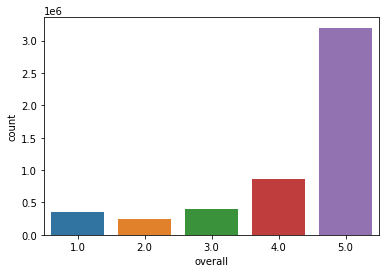

In [38]:
# Check if dataset is balanced or imbalanced
sns.countplot(x=df_import['overall'])

In [39]:
# Dataset it imbalanced and simplified approach to taking stratified sample

df_list=[]
for score in sorted(df_import['overall'].unique().tolist()):
    current_df = df_import.loc[df_import['overall']==score,:]
    df_list.append(current_df.sample(n=50000,random_state=42))

In [40]:
df = pd.concat(df_list)

In [41]:
# rename columns
df.rename(columns={'overall':'label_rating'},inplace=True)

In [42]:
df.head(2)

,label_rating,review
5402842,1.0,"Pretty poor performance. I purchased these because I wanted to try a set of wireless bluetooth earbuds and honestly, they aren't very good.\n\nAfter connecting my ipod to the earbuds, I put my ipod into my pocket. Just walking with it like this caused the earbuds to crackle and lose signal. It couldn't have been more than a few feet of distance between them but this problem was happening way too frequently. It was so bad I went back to my old wired headphones.\n\nI guess these might be for someone, but if the range is going to be this restricted, don't even bother. If you plan on using these while exercising or even just walking you should probably pass.\n\nUpdate: they really suck. Worst headphones I've ever purchased. The bluetooth is garbage.\n\nThe company is from China so good luck getting a return."
6343421,1.0,bad buy my hand book recommends that for my nokia but phone couldn't recognise it so very disappointed with it because it is junk


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 5402842 to 5439887
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   label_rating  250000 non-null  float64
 1   review        250000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 5.7+ MB


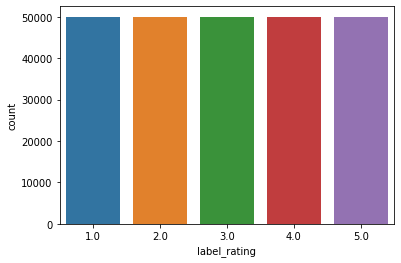

In [44]:
# balanced dataset
sns.countplot(x=df['label_rating'])

In [45]:
df.describe(include='all')

,label_rating,review
count,250000.000000,250000
unique,NaN,249985
top,NaN,works great works great
freq,NaN,2
mean,3.000000,NaN
std,1.414216,NaN
min,1.000000,NaN
25%,2.000000,NaN
50%,3.000000,NaN
75%,4.000000,NaN


# Prepare data for sentiment analysis

## Pre-process data

**Steps**

- Set text to lowercase
- Remove the HTML tags and URLs
- Remove contractions
- Remove punctuation
- Remove stopwords
- optional: Lemmatization

In [46]:
# convert review text to lower case
df['review_clean'] = df['review'].apply(lambda s: s.lower())

In [48]:
# Remove the HTML tags and URLs from reviews if still existent

# via beautifulsoup
df['review_clean'] = df['review_clean'].apply(lambda x: BeautifulSoup(x).get_text())

# via regex
df['review_clean'] = df['review_clean'].apply(lambda x: re.sub(r'http\S+', '', x))

KeyboardInterrupt: ignored

In [50]:
def remove_contractions(c):
    c = re.sub(r'\’m', ' am', c)
    c = re.sub(r'\’d', ' would',c)
    c = re.sub(r'can\’t', 'can not',c)
    c = re.sub(r'n\’t', ' not', c)
    c= re.sub(r'\’re', ' are', c)
    c = re.sub(r'\’s', ' is', c)
    c = re.sub(r'\’ll', ' will', c)
    c = re.sub(r'\’t', ' not', c)
    c = re.sub(r'\’ve', ' have', c)
    c = re.sub(r'won’t', 'will not',c)
    c = re.sub(r'would’t', 'would not',c)
    c = re.sub(r'could’t', 'could not',c)

    return c

df['review_clean'] = df['review_clean'].apply(lambda x: remove_contractions(x))

In [51]:
# remove punctuation
df['review_clean']=[re.sub('[^\w\s]+', '', s) for s in df['review'].tolist()]

In [52]:
# remove digits
df['review_clean']=[re.sub('[\d+]+', '', s) for s in df['review'].tolist()]

In [53]:
# use gensim to remove stopwords
print(STOPWORDS)

# do not remove 'not'

all_stopwords_gensim = STOPWORDS
sw_list = {"not"}
all_stopwords_gensim = STOPWORDS.difference(sw_list)

df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

frozenset({'onto', 'indeed', 'really', 'amount', 'those', 'i', 'everywhere', 'why', 'anyway', 'within', 'except', 'everything', 'are', 'up', 'besides', 'take', 'give', 'her', 'where', 'you', 'yourselves', 'doing', 'seem', 'herein', 'bill', 'whom', 'rather', 'three', 'himself', 'de', 'describe', 'whereas', 'eg', 'him', 'out', 'an', 'please', 'into', 'often', 'nevertheless', 'sometimes', 'part', 'whatever', 'whereupon', 'again', 'around', 'two', 'latter', 'be', 'afterwards', 'first', 'being', 'front', 'either', 'could', 'we', 'at', 'my', 'other', 'becomes', 'nothing', 'thereafter', 'against', 'can', 'over', 'what', 'when', 'done', 'neither', 'never', 'themselves', 'thick', 'thin', 'mine', 'move', 'it', 'nowhere', 'amoungst', 'under', 'six', 'find', 'seeming', 'just', 'one', 'twelve', 'perhaps', 'fify', 'any', 'hereafter', 'me', 'wherein', 'hasnt', 'had', 'through', 'if', 'thru', 'five', 'namely', 'unless', 'here', 'which', 'anyhow', 'cry', 'down', 'anyone', 'now', 'much', 'then', 'once',

In [54]:
# Lemmatize with spacy
## Initialize spacy ‘en’ model, keeping only the component required for lemmatization and creating an engine:

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc]
    return lemma_list


def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

In [55]:
# df['review_lemma'] = preprocess_pipe(df['review_clean'])

# df.head()

## Visualize word frequency

In [56]:
#Filter data
review_1 = df[df["label_rating"]==1].dropna()
review_2 = df[df["label_rating"]==2].dropna()
review_3 = df[df["label_rating"]==3].dropna()
review_4 = df[df["label_rating"]==4].dropna()
review_5 = df[df["label_rating"]==5].dropna()

In [57]:
# custom function for ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [58]:
# custom function for horizontal bar chart
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Bar chart for 5 Star Reviews

freq_dict = defaultdict(int)
for sent in review_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Bar chart for 4 Star Reviews

freq_dict = defaultdict(int)
for sent in review_4["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'lightgreen')

# Bar chart for 3 Star Reviews

freq_dict = defaultdict(int)
for sent in review_3["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

# Bar chart for 2 Star 

freq_dict = defaultdict(int)
for sent in review_2["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace3 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Bar chart for 1 Star Reviews

freq_dict = defaultdict(int)
for sent in review_1["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace4 = horizontal_bar_chart(fd_sorted.head(25), 'darkred')

# Create subplots
fig = tls.make_subplots(rows=5, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of 5 Star reviews", "Frequent words of 4 Star reviews",
                                          "Frequent words of 3 Star reviews","Frequent words of 2 Star reviews","Frequent words of 1 Star reviews"])

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig.append_trace(trace3, 4, 1)
fig.append_trace(trace4, 5, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

# Base model

In [59]:
# convert dataframe to numpy array

data = df.to_numpy()

In [60]:
# Set first column 'label_rating' as label and column 2 'review' as feature

y = data[:, 0].astype('float32')  # Label=0 oder 1
X = data[:, 2]

## Split data in train and test datasets

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenize text

In [62]:
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [63]:
# print vocabulary
print(vectorizer.vocabulary_)

{'carefull': 1237, 'purchased': 6730, 'old': 5880, 'files': 3224, 'ide': 4188, 'drives': 2591, 'first': 3278, 'able': 10, 'seat': 7596, 'dock': 2480, 'buy': 1128, 'extention': 3071, 'cable': 1149, 'power': 6496, 'extender': 3062, 'work': 9833, 'at': 514, 'unit': 9278, 'worked': 9837, 'wonderfully': 9819, 'simply': 7871, 'turn': 9152, 'remove': 7107, 'drive': 2587, 'when': 9710, 'that': 8791, 'to': 8936, 'sector': 7610, 'corrupted': 1849, 'this': 8836, 'google': 3713, 'backup': 635, 'sync': 8622, 'working': 9842, 'probably': 6595, 'so': 8029, 'turned': 9153, 'ruined': 7424, 'camera': 1184, 'tripod': 9106, 'great': 3760, 'glasses': 3669, 'fit': 3284, 'look': 5028, 'better': 783, 'receive': 6912, 'doa': 2477, 'not': 5748, 'charge': 1348, 'small': 7978, 'reset': 7191, 'button': 1126, 'usb': 9384, 'input': 4379, 'plug': 6392, 'push': 6742, 'blink': 856, 'orange': 5950, 'ready': 6880, 'start': 8276, 'charging': 1353, 'bright': 1018, 'idea': 4189, 'seam': 7586, 'plastic': 6356, 'right': 7318,

In [64]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## ML Model

### Multinominal Naive Bayes Classifier

Check accuracy of classifier to have a benchmark to evaluate the performance of the neural nets in addition to the baseline model which will be introduced below.

In [65]:
multi_model = MultinomialNB()
multi_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [66]:
print('Accurracy of Train data:', multi_model.score(X_train_vectorized, y_train))
print('Accurracy of Test data:', multi_model.score(X_test_vectorized, y_test))

Accurracy of Train data: 0.599595
Accurracy of Test data: 0.56854


In [67]:
# Confusion Matrix
y_pred_multi = multi_model.predict(X_test_vectorized)

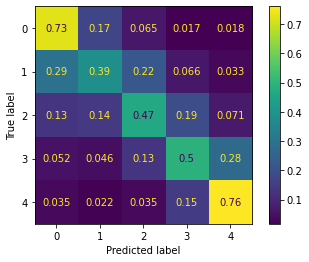

In [68]:
cm = confusion_matrix(y_test, y_pred_multi, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Comment

- Accuracy: 59%
- 1 Star and 5 star reviews are much more accurately predicted than other reviews
- borders between 5 and 4 as well as between 1 and 2 star reviews seem fluent as there are many misclassifications (as expected)

# DL Models

## Prep data

In [69]:
def find_max_list_length(list):
  list_len = [len(i) for i in list]
  return np.max(np.array(list_len))

In [70]:
id2label={0:1, 1:2, 2:3, 3:4, 4:5}

### 5 label prep

In [71]:
def build_data(df):
  data = df.to_numpy()
  y = data[:, 0].astype('float32')  # Label=0 oder 1
  X = data[:, 2]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X, y, X_train, X_test, y_train, y_test

In [72]:
# Define evaluation of predictions

def get_y_pred(preds):
  y_pred = []
  for pred in preds:
    pred = np.argmax(pred)
    y_pred.append(id2label[pred])
  return y_pred

def convert_cat_label(cat_labels):
  y_test=[]
  for cat_label in cat_labels:
    cat_label = np.argmax(cat_label)
    y_test.append(id2label[cat_label])
  return y_test

In [73]:
# Define plot for visualization of training

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### 3 label prep

In [74]:
five_labels_to_three_labels = {
    1:0,
    2:0,
    3:1,
    4:2,
    5:2
}
id2three_labels = {
    0:"negative",
    1:"neutral",
    2:"positive"
}

def convert_y_into_three_labels(y_labels):
  y_three_ = []
  y_three_string_ = []
  for label in y_labels:
    label = int(label)
    
    new_label = int(five_labels_to_three_labels[label])
    new_label_string = id2three_labels[new_label]

    y_three_.append(new_label)
    y_three_string_.append(new_label_string)

  return np.array(y_three_), y_three_string_

y_train_three, y_train_three_string = convert_y_into_three_labels(y_train)
y_test_three, y_test_three_string = convert_y_into_three_labels(y_test)

## Tokenize text


*   Embedding layer expects the words to be in numeric form
*  Using Tokenizer function from keras.preprocessing.text library
*   Method fit_on_text trains the tokenizer
*   Method texts_to_sequences converts sentences to their numeric form

In [75]:
X, y, X_train, X_test, y_train, y_test = build_data(df)

In [76]:
# create tokens

num_words = 10000
word_tokenizer = Tokenizer(num_words=num_words,oov_token='<OOV>')
word_tokenizer.fit_on_texts(X_train)

In [77]:
# create sequences

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [78]:
print('max length of tokens', find_max_list_length(X_train))

max length of tokens 1527


Max length is 2423, will be truncated.

In [79]:
# Word index length

len(word_tokenizer.word_index)
# vocab_size = len(word_tokenizer.word_index) + 1

76300

In [80]:
# Top 50 words

print(dict(itertools.islice(word_tokenizer.word_index.items(), 50)) )

{'<OOV>': 1, 'i': 2, 'not': 3, 'the': 4, 'it': 5, 'good': 6, 'great': 7, 'this': 8, 'use': 9, 'work': 10, 'works': 11, 'like': 12, "it's": 13, 'product': 14, 'quality': 15, 'stars': 16, "don't": 17, 'time': 18, 'case': 19, 'sound': 20, 'price': 21, 'camera': 22, 'better': 23, 'bought': 24, 'cable': 25, "i'm": 26, 'nice': 27, 'little': 28, 'buy': 29, 'one': 30, 'usb': 31, 'if': 32, 'got': 33, 'battery': 34, 'screen': 35, 'so': 36, "doesn't": 37, 'but': 38, 'worked': 39, "didn't": 40, 'well': 41, 'need': 42, 'fine': 43, 'unit': 44, 'fit': 45, 'power': 46, 'device': 47, 'tv': 48, 'drive': 49, 'way': 50}


In [81]:
# Top 100 words

counter=0
for key in dict(itertools.islice(word_tokenizer.word_index.items(), 100)):
  print(counter, key)
  counter+=1

0 <OOV>
1 i
2 not
3 the
4 it
5 good
6 great
7 this
8 use
9 work
10 works
11 like
12 it's
13 product
14 quality
15 stars
16 don't
17 time
18 case
19 sound
20 price
21 camera
22 better
23 bought
24 cable
25 i'm
26 nice
27 little
28 buy
29 one
30 usb
31 if
32 got
33 battery
34 screen
35 so
36 doesn't
37 but
38 worked
39 didn't
40 well
41 need
42 fine
43 unit
44 fit
45 power
46 device
47 tv
48 drive
49 way
50 easy
51 i've
52 new
53 problem
54 in
55 you
56 bad
57 for
58 thing
59 working
60 small
61 my
62 right
63 they
64 amazon
65 set
66 card
67 want
68 phone
69 keyboard
70 a
71 cheap
72 hard
73 on
74 all
75 months
76 pretty
77 money
78 tried
79 light
80 bit
81 very
82 can't
83 long
84 no
85 laptop
86 and
87 ok
88 far
89 that
90 recommend
91 these
92 sure
93 love
94 video
95 star
96 know
97 think
98 purchased
99 going


## Set parameters

In [82]:
embedding_dim = 16
max_length = 256
trunc_type='post'
padding_type='post'
num_epochs = 30

# This callback will stop the training when there is no improvement in  the loss for 5 consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

### Padding

In [83]:
# Padding all reviews to fixed length 

X_train = pad_sequences(X_train, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=max_length, truncating='post')

### Encode y labels (5)

In [84]:
print(y_train[0],
y_train[150],
y_train[1501])

y_train = keras.utils.to_categorical(y_train-1, num_classes = 5)
y_test = keras.utils.to_categorical(y_test-1, num_classes = 5)

print(y_train[0])
print(y_train[150])
print(y_train[1501])

2.0 4.0 4.0
[0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]


## Model 1: Sequential,Dense

The first layer is the embedding layer where all the parameters have been defined and explained before. The second layer is ‘GlobalAveragePooling1D’  which flattens the vector. Originally the data is three-dimensional (batch_size x steps x features). GlobalAveragePooling1D makes it (batch_size x features).

In [85]:
num_outputs = 5

model1 = keras.Sequential([
    keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(num_outputs, activation='softmax')
])

model1.summary()

model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 160,357
Trainable params: 160,357
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
3118/3125 [============================>.] - ETA: 0s - loss: 1.2674 - accuracy: 0.4430
Epoch 1: val_accuracy improved from -inf to 0.50582, saving model to best_model1.hdf5
3125/3125 [==============================] - 16s 4ms/step - loss: 1.2670 - accuracy: 0.4431 - val_loss: 1.1182 - val_accuracy: 0.5058
Epoch 2/30
3111/3125 [============================>.] - ETA: 0s - loss: 1.0452 - accuracy: 0.5628
Epoch 2: val_accuracy improved from 0.50582 to 0.58066, saving model to best_model1.hdf5
3125/3125 [==============================] - 12s 4ms/step - loss: 1.0451 - accuracy: 0.5628 - val_loss: 1.0100 - val_accuracy: 0.5807
Epoch 3/30
3125/3125 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.5940
Epoch 3: val_accuracy improved from 0.58066 to 0.58852, saving model to best_model1.hdf5
3125/3125 [==============================] - 18s 6ms/step - loss: 0.9715 - accuracy: 0.5940 - val_loss: 0.9807 - val_accuracy: 0.5885
Epoch 4/30
3116/3125 [==================

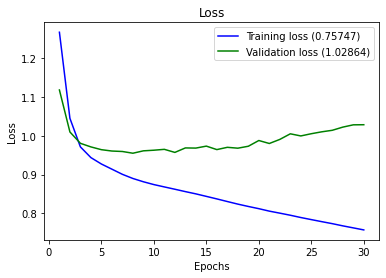

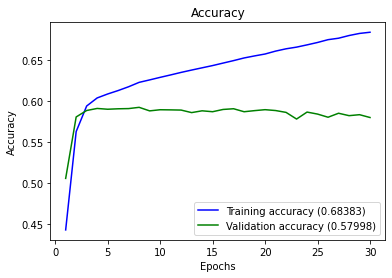

In [86]:
# Callback to save the Keras model
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)

# This callback will stop the training when there is no improvement in  the loss for 5 consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history1 = model1.fit(X_train, y_train, batch_size = 64, epochs=num_epochs, validation_data=(X_test, y_test),callbacks=[checkpoint1,callback])
plot_history(history1)

In [87]:
preds1 = model1.predict(X_test)

y_pred1 = get_y_pred(preds1)
y_test = convert_cat_label(y_test)

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           1       0.67      0.65      0.66      9912
           2       0.48      0.47      0.48      9938
           3       0.49      0.51      0.50     10036
           4       0.55      0.53      0.54      9914
           5       0.69      0.73      0.71     10200

    accuracy                           0.58     50000
   macro avg       0.58      0.58      0.58     50000
weighted avg       0.58      0.58      0.58     50000



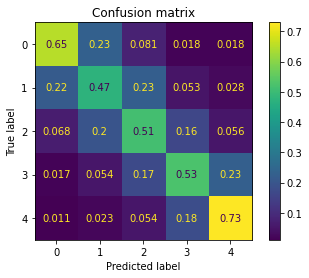

In [88]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred1, labels=list(id2label.values()),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion matrix')
plt.show()

Comment

- slightly better result than MultinomialNB classifier 
- similar prediction pattern as MultinomialNB classifier 


Test new sentence

In [89]:
new_test_sentence = "I do not like the product. The USB stick doesn't work."
test_sequences = word_tokenizer.texts_to_sequences(new_test_sentence)
padded_test_sentence = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model1.predict(padded_test_sentence)[0])
print('Predicted label:',
np.argmax(model1.predict(padded_test_sentence)[0])+1)

[0.10890578 0.12589382 0.22852027 0.21204941 0.3246307 ]
Predicted label: 5


In [90]:
# Check predictions for different tokens 
## just to get an impressions, model actually evaluates sequences

for text in list(dict(itertools.islice(word_tokenizer.word_index.items(), 100)).keys()):
  sequences = word_tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  
  print('\nPredicted word and label:', text, " -- ", np.argmax(model1.predict(padded)[0])+1)


Predicted word and label: <OOV>  --  5

Predicted word and label: i  --  5

Predicted word and label: not  --  5

Predicted word and label: the  --  5

Predicted word and label: it  --  5

Predicted word and label: good  --  5

Predicted word and label: great  --  5

Predicted word and label: this  --  5

Predicted word and label: use  --  5

Predicted word and label: work  --  5

Predicted word and label: works  --  5

Predicted word and label: like  --  5

Predicted word and label: it's  --  5

Predicted word and label: product  --  5

Predicted word and label: quality  --  5

Predicted word and label: stars  --  5

Predicted word and label: don't  --  5

Predicted word and label: time  --  5

Predicted word and label: case  --  5

Predicted word and label: sound  --  5

Predicted word and label: price  --  5

Predicted word and label: camera  --  5

Predicted word and label: better  --  3

Predicted word and label: bought  --  3

Predicted word and label: cable  --  5

Predicted wo

In [91]:
top = []
bottom = []
for text in tqdm(list(dict(itertools.islice(word_tokenizer.word_index.items(), 100)).keys())):
  sequences = word_tokenizer.texts_to_sequences(text)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  pred = model1.predict(padded)[0]
  prediction = np.argmax(pred)+1
  # Take highest
  if prediction == 5:
    top.append([text, max(pred)])

  # Take lower
  if prediction <= 2:
    bottom.append([text, max(pred)])
pd.DataFrame(top, columns=["word","pred"]).sort_values("pred", ascending=False)[:10]

pd.DataFrame(bottom, columns=["word","pred"]).sort_values("pred", ascending=False)[:10]

## Model 2: Bidirectional Layers

Bidirectional layer maximize the order sensitivity of the RNNs: essentially it consists of two RNNs (LSTMs or GRUs) that process the input sequence in one different direction to finally merge representations. By doing this, they’re able to catch more complex patterns than a single RNN layer would catch. In other words, one of the layers interprets the sequences in chronological order and the second one do so in anti-chronological order, that’s why Bidirectional RNNs are widely used, because they offer greater performance than regular RNNs.

In [92]:
num_outputs_bi = 5
X, y, X_train, X_test, y_train, y_test = build_data(df)

In [93]:
num_words = 10000
word_tokenizer = Tokenizer(num_words=num_words,oov_token='<OOV>')
word_tokenizer.fit_on_texts(X_train)

# create sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)


# Padding all reviews to fixed length 
X_train = pad_sequences(X_train, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=max_length, truncating='post')

y_train = keras.utils.to_categorical(y_train-1, num_classes = 5)
y_test = keras.utils.to_categorical(y_test-1, num_classes = 5)

model2bi = Sequential()
model2bi.add(layers.Embedding(num_words, embedding_dim, input_length=max_length))
model2bi.add(layers.Bidirectional(layers.LSTM(32,dropout=0.7)))
model2bi.add(layers.Dense(16,activation='relu'))
model2bi.add(layers.Dense(num_outputs_bi,activation='softmax'))

model2bi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 173,669
Trainable params: 173,669
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
6247/6250 [============================>.] - ETA: 0s - loss: 1.0592 - accuracy: 0.5376
Epoch 1: val_accuracy improved from -inf to 0.59366, saving model to best_model3bi.hdf5
6250/6250 [==============================] - 109s 17ms/step - loss: 1.0592 - accuracy: 0.5376 - val_loss: 0.9277 - val_accuracy: 0.5937
Epoch 2/30
6248/6250 [============================>.] - ETA: 0s - loss: 0.9688 - accuracy: 0.5807
Epoch 2: val_accuracy improved from 0.59366 to 0.60044, saving model to best_model3bi.hdf5
6250/6250 [==============================] - 104s 17ms/step - loss: 0.9688 - accuracy: 0.5806 - val_loss: 0.9151 - val_accuracy: 0.6004
Epoch 3/30
6249/6250 [============================>.] - ETA: 0s - loss: 0.9433 - accuracy: 0.5915
Epoch 3: val_accuracy improved from 0.60044 to 0.60728, saving model to best_model3bi.hdf5
6250/6250 [==============================] - 114s 18ms/step - loss: 0.9433 - accuracy: 0.5915 - val_loss: 0.8998 - val_accuracy: 0.6073
Epoch 4/30
6248/6250 [======

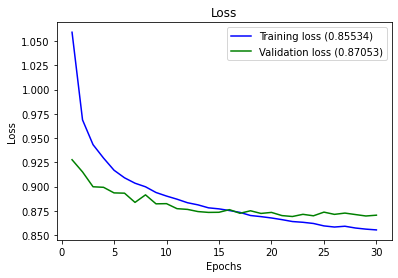

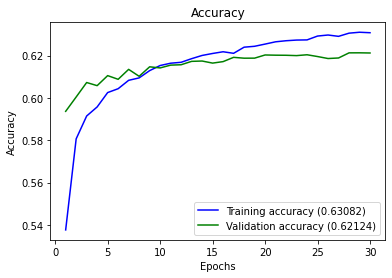

In [94]:
model2bi.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpointbi = ModelCheckpoint("best_model3bi.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history2bi = model2bi.fit(X_train, y_train, batch_size = 32, epochs=num_epochs, validation_data=(X_test, y_test),callbacks=[checkpointbi,callback])
plot_history(history2bi)

In [95]:
preds_bi = model2bi.predict(X_test)
y_pred2bi = get_y_pred(preds_bi)
y_test = convert_cat_label(y_test)
print(classification_report(y_test, y_pred2bi))

              precision    recall  f1-score   support

           1       0.69      0.73      0.71      9912
           2       0.51      0.55      0.53      9938
           3       0.57      0.49      0.53     10036
           4       0.61      0.55      0.58      9914
           5       0.71      0.79      0.75     10200

    accuracy                           0.62     50000
   macro avg       0.62      0.62      0.62     50000
weighted avg       0.62      0.62      0.62     50000



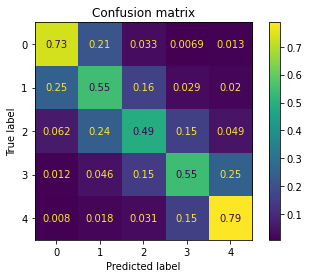

In [96]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred2bi, labels=list(id2label.values()),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion matrix')
plt.show()

In [97]:
print(model2bi.predict(padded_test_sentence)[0])
print('Predicted label:',
np.argmax(model2bi.predict(padded_test_sentence)[0])+1)

[0.1016206  0.09877989 0.15308714 0.22929922 0.4172132 ]
Predicted label: 5


## Attention Model with 5 labels

Test with attention layer from keras nlp for 10 epochs

In [133]:
num_outputs_bi = 5
X, y, X_train, X_test, y_train, y_test = build_data(df)

In [134]:
# create tokens

num_words = 10000
word_tokenizer = Tokenizer(num_words=num_words)
word_tokenizer.fit_on_texts(X_train)

# encode labels
y_train = keras.utils.to_categorical(y_train-1, num_classes = 5)
y_test = keras.utils.to_categorical(y_test-1, num_classes = 5)

# create sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Padding all reviews to fixed length

X_train = pad_sequences(X_train, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=max_length, truncating='post')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 256, 16)          164096    
 g_13 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_13 (Tra  (None, 256, 16)          3280      
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_14  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dense_31 (Dense)            (None, 5)               

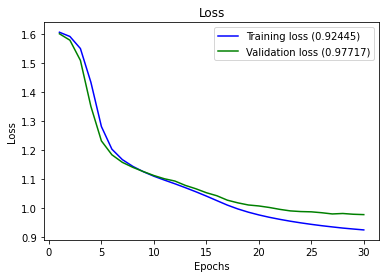

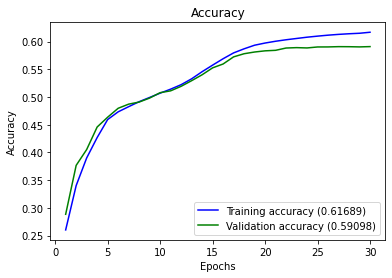

In [135]:
# set output dim (3 or 5)

output_dim = 5

model_attention = keras.models.Sequential()
model_attention.add(keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=num_words,
                                                     sequence_length=max_length,
                                                     embedding_dim=embedding_dim, input_shape=(256,)))

model_attention.add(keras_nlp.layers.TransformerEncoder(num_heads=4, intermediate_dim=64))
model_attention.add(keras.layers.GlobalAveragePooling1D())
model_attention.add(keras.layers.Dense(32, activation='relu'))
model_attention.add(keras.layers.Dense(output_dim, activation='softmax'))
model_attention.summary()


model_attention.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics='accuracy')

checkpoint_att = ModelCheckpoint("best_model_att.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history_attention = model_attention.fit(X_train, y_train, batch_size = 32, epochs=30, validation_data=(X_test, y_test),callbacks=[checkpoint_att])
plot_history(history_attention)

### Evaluate attention model with 5 labels

[0.378803   0.26960036 0.18675578 0.08037341 0.0844675 ]
Predicted label: 1
              precision    recall  f1-score   support

           1       0.67      0.70      0.68      9912
           2       0.49      0.50      0.49      9938
           3       0.56      0.45      0.50     10036
           4       0.55      0.51      0.53      9914
           5       0.67      0.79      0.72     10200

    accuracy                           0.59     50000
   macro avg       0.59      0.59      0.59     50000
weighted avg       0.59      0.59      0.59     50000



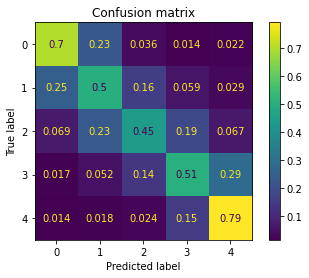

In [136]:
print(model_attention.predict(padded_test_sentence)[0])
print('Predicted label:',
np.argmax(model_attention.predict(padded_test_sentence)[0])+1)


preds_att = model_attention.predict(X_test)
y_pred_att = get_y_pred(preds_att)
y_test = convert_cat_label(y_test)
print(classification_report(y_test, y_pred_att))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred_att, labels=list(id2label.values()),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion matrix')
plt.show()

Model training is comparably slow. Result is mostly in line with previous models. Model seems to overfit in the later epochs. Next, test model performance with 3 labels: negative, neutral or positive.

**Summary**

Best model: Bidirectional Layers Model with 62% accuracy on 5 labels.

## Attention Model with 3 labels

In [125]:
num_outputs_bi = 5
X, y, X_train, X_test, y_train, y_test = build_data(df)

In [127]:
# create tokens

num_words = 10000
word_tokenizer = Tokenizer(num_words=num_words)
word_tokenizer.fit_on_texts(X_train)

# encode labels
y_train_three, y_train_three_string = convert_y_into_three_labels(y_train)
y_test_three, y_test_three_string = convert_y_into_three_labels(y_test)
y_train_three = keras.utils.to_categorical(y_train_three-1, num_classes = 3)
y_test_three = keras.utils.to_categorical(y_test_three-1, num_classes = 3)

# create sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Padding all reviews to fixed length

X_train = pad_sequences(X_train, padding='post', maxlen=max_length, truncating='post')
X_test = pad_sequences(X_test, padding='post', maxlen=max_length, truncating='post')

In [128]:
output_dim = 3

model_attention3 = keras.models.Sequential()
model_attention3.add(keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=num_words,
                                                     sequence_length=max_length,
                                                     embedding_dim=embedding_dim, input_shape=(256,)))

model_attention3.add(keras_nlp.layers.TransformerEncoder(num_heads=4, intermediate_dim=64))
model_attention3.add(keras.layers.GlobalAveragePooling1D())
model_attention3.add(keras.layers.Dense(32, activation='relu'))
model_attention3.add(keras.layers.Dense(output_dim, activation='softmax'))
model_attention3.summary()


model_attention3.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 256, 16)          164096    
 g_12 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_12 (Tra  (None, 256, 16)          3280      
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_13  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_28 (Dense)            (None, 32)                544       
                                                                 
 dense_29 (Dense)            (None, 3)               

In [129]:
checkpoint_att3 = ModelCheckpoint("best_model_att3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history_attention3 = model_attention3.fit(X_train, y_train_three, batch_size = 64, epochs=40, validation_data=(X_test, y_test_three),callbacks=[checkpoint_att3])

Epoch 1/40
3122/3125 [============================>.] - ETA: 0s - loss: 1.0540 - accuracy: 0.4733
Epoch 1: val_accuracy improved from -inf to 0.48366, saving model to best_model_att3.hdf5
3125/3125 [==============================] - 52s 16ms/step - loss: 1.0540 - accuracy: 0.4733 - val_loss: 1.0482 - val_accuracy: 0.4837
Epoch 2/40
3123/3125 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.5490
Epoch 2: val_accuracy improved from 0.48366 to 0.53284, saving model to best_model_att3.hdf5
3125/3125 [==============================] - 44s 14ms/step - loss: 1.0409 - accuracy: 0.5490 - val_loss: 1.0341 - val_accuracy: 0.5328
Epoch 3/40
3124/3125 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.5893
Epoch 3: val_accuracy improved from 0.53284 to 0.59614, saving model to best_model_att3.hdf5
3125/3125 [==============================] - 44s 14ms/step - loss: 1.0205 - accuracy: 0.5893 - val_loss: 1.0061 - val_accuracy: 0.5961
Epoch 4/40
3122/3125 [===

In [130]:
preds_att_3 = model_attention3.predict(X_test)
y_predsatt_3 = get_y_pred(preds_att_3)
y_true_three = convert_cat_label(y_test_three)
print(classification_report(y_true_three, y_predsatt_3))

              precision    recall  f1-score   support

           1       0.47      0.35      0.40     10036
           2       0.84      0.84      0.84     20114
           3       0.77      0.87      0.81     19850

    accuracy                           0.75     50000
   macro avg       0.69      0.68      0.68     50000
weighted avg       0.74      0.75      0.74     50000



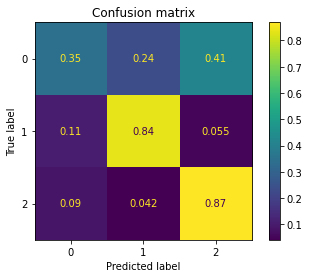

In [131]:
cm_att = confusion_matrix(y_true=y_true_three, y_pred=y_predsatt_3,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_att).plot()
plt.title('Confusion matrix')
plt.show()

In [132]:
print(model_attention3.predict(padded_test_sentence)[0])
print('Predicted label:',
np.argmax(model_attention3.predict(padded_test_sentence)[0])+1)

[0.3137732  0.08146132 0.6047654 ]
Predicted label: 3


Comment 3 layer attention model
- performance improved (as anticipated) from 62% with 5 labels to 75% accuracy with 3 labels
- extracting overall sentiment vs predicting # stars
- poor prediction of negative reviews

**Final notes**

Reasons that might prevent models from performing better

- no standardized definition of what defines a specific star review and what differentiates them
- relatively small sample size
- data quality: long product descriptions that create noise


Ideas to improve the prediction

- intensify hyperparameter tuning
- extend data preparation, more cleaning
- take larger sample size
